In [3]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys

In [4]:
sys.path

['d:\\Desktop\\Lipschitz_DSNN\\trial_notebooks',
 'd:\\anaconda_neel\\python38.zip',
 'd:\\anaconda_neel\\DLLs',
 'd:\\anaconda_neel\\lib',
 'd:\\anaconda_neel',
 '',
 'd:\\anaconda_neel\\lib\\site-packages',
 'd:\\anaconda_neel\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'd:\\anaconda_neel\\lib\\site-packages\\win32',
 'd:\\anaconda_neel\\lib\\site-packages\\win32\\lib',
 'd:\\anaconda_neel\\lib\\site-packages\\Pythonwin',
 'd:\\anaconda_neel\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\NEELKANTH RAWAT\\.ipython']

In [5]:
sys.path.append('D:\\Desktop\\Lipschitz_DSNN') 

Now I can start loading up the module and data and try to replicate some of the examples to understand the algorithm well

In [6]:
# let's load a saved configuration
import json

In [7]:
# Load the JSON file
file_config_training="D:\Desktop\Lipschitz_DSNN\configs\config_1d.json"
with open(file_config_training, 'r') as f:
    config = json.load(f)

config

{'activation_fn_params': {'activation_type': 'linearspline',
  'groupsort_groupsize': 5,
  'prelu_init': -1,
  'lipschitz_constrained': True,
  'spline_init': 'relu',
  'spline_range': 0.5,
  'spline_scaling_coeff': True,
  'spline_size': 101,
  'lmbda': 1e-07},
 'dataset': {'function_type': 'f1',
  'number_knots': 9,
  'testing_dataset_size': 10000,
  'training_dataset_size': 1000},
 'exp_name': 'test',
 'log_dir': '1d_exps/ortho',
 'net_params': {'bias': True,
  'layer_sizes': [1, 10, 10, 10, 1],
  'projection': 'orthonormalize',
  'weight_initialization': 'He_uniform'},
 'optimizer': {'lr_spline_coeffs': 5e-05,
  'lr_spline_scaling_coeffs': 0.0005,
  'lr_weights': 0.002},
 'seed': 5,
 'training_options': {'batch_size': 10,
  'epochs': 1000,
  'nbr_models': 25,
  'num_workers': 1}}

`BaseModel.py` and `simple_fc.py`: For Simple Fully Connected network

In [8]:
from architectures.simple_fc import SimpleFC

In [10]:
config["training_options"], config['net_params']

({'batch_size': 10, 'epochs': 1000, 'nbr_models': 25, 'num_workers': 1},
 {'bias': True,
  'layer_sizes': [1, 10, 10, 10, 1],
  'projection': 'orthonormalize',
  'weight_initialization': 'He_uniform'})

In [13]:
config['activation_fn_params']

{'activation_type': 'linearspline',
 'groupsort_groupsize': 5,
 'prelu_init': -1,
 'lipschitz_constrained': True,
 'spline_init': 'relu',
 'spline_range': 0.5,
 'spline_scaling_coeff': True,
 'spline_size': 101,
 'lmbda': 1e-07}

In [28]:
### model parameters
network_param = {'bias': True,
    'layer_sizes': [2, 3, 4, 5, 1], ### we will consider 2-D Example later on
    'projection': 'orthonormalize',
    'weight_initialization': 'He_uniform'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 3,### this is of interest [-3,3]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 7,#101,###
    'lmbda': 1e-07}### this is of interest

### defining the model
ds_simple_fc_model= SimpleFC(network_parameters=network_param,
                             **additional_network_params)
ds_simple_fc_model

SimpleFC(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=3, bias=True)
    (1): LinearSpline(mode=fc, num_activations=3, init=relu, size=7, grid=1.000, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=3, out_features=4, bias=True)
    (3): LinearSpline(mode=fc, num_activations=4, init=relu, size=7, grid=1.000, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=4, out_features=5, bias=True)
    (5): LinearSpline(mode=fc, num_activations=5, init=relu, size=7, grid=1.000, lipschitz_constrained=True.)
    (6): LipschitzLinear(in_features=5, out_features=1, bias=True)
  )
)

In [68]:
ds_simple_fc_model.using_splines, ds_simple_fc_model.TV2()

(True, tensor(12., grad_fn=<SelectBackward0>))

Area Classification Problem

In [56]:
### Area Classification Problem
import numpy as np

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5*x)

# Define the label function (vectorized)
def S_shape_label_fn(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)

# Generate random x_mat
num_dp = 2000  # Assuming num_dp is defined
x_mat = np.random.uniform(-1, 1, size=(num_dp, 2))

# Create y_mat
y_mat = S_shape_label_fn(x_mat)

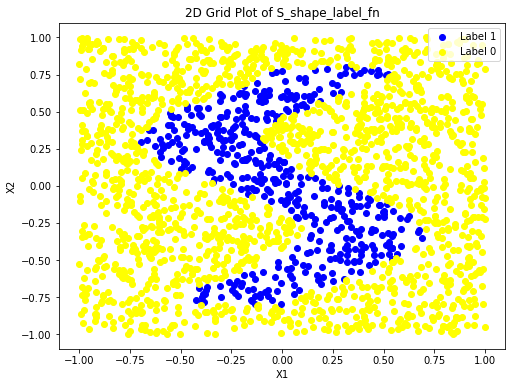

In [61]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat[y_mat == 1, 0], x_mat[y_mat == 1, 1], color='blue', label='Label 1')
plt.scatter(x_mat[y_mat == 0, 0], x_mat[y_mat == 0, 1], color='yellow', label='Label 0')
plt.title('2D Grid Plot of S_shape_label_fn')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.grid(True)
plt.show()

In [63]:
from torch.utils.data import Dataset
### later transfer it to the 
class CustomDataset(Dataset):
    """
    Custom dataset class for our problem.
    """
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y


In [65]:
import torch
import os
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils import tensorboard
from architectures.simple_fc import SimpleFC
from utils import metrics, utilities, spline_utils
import matplotlib.pyplot as plt
from layers.lipschitzlinear import LipschitzLinear
from dataloader.Function_1D import (Function1D, generate_testing_set,
    slope_1_ae, slope_1_flat, cosines, threshold)
from activations.linearspline import LinearSpline

In [66]:
def slope_normalization(cs, T):
    lipschitz = torch.max(torch.abs(cs[:, 1:] - cs[:,:-1]), dim=1)[0]
    new_cs = T * torch.div(cs.T, lipschitz).T

    return new_cs

In [ ]:
# writing a general trainer function for our classification problem
import torch
import os
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# from torch.utils import tensorboard
from utils import metrics, utilities

class Trainer_classification:
    """
    Trainer class for your classification problem.
    """
    def __init__(self, model, xdata, ydata, criterion, config, seed, device):
        self.model = model
        self.x = xdata
        self.y = ydata
        self.config = config
        self.device = device
        self.criterion = criterion 

        # Split dataset into train and validation sets
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(xdata, ydata,
                                                                    test_size=config["training_options"]["validation_split"], 
                                                                    random_state=seed)

        # Prepare dataloaders 
        self.train_dataloader = DataLoader(CustomDataset(self.x_train, self.y_train), 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=True)
        self.val_dataloader = DataLoader(CustomDataset(self.x_val, self.y_val), 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=False)

        # Set up the optimizer 
        self.set_optimization()

        # average train and val epoch loss
        self.avg_train_loss_epoch=[]
        self.avg_val_loss_epoch = []

        # Stats to save about the models

    ### setting up the optimizer
    def set_optimization(self):
        """ """
        self.optimizers = []
        #for i in range(self.nbr_models):
        params_list = [{'params': spline_utils.get_no_spline_coefficients(self.model), \
                        'lr': self.config["optimizer"]["lr_weights"]}]
        if self.model.using_splines:
            params_list.append({'params': spline_utils.get_spline_coefficients(self.model), \
                                'lr': self.config["optimizer"]["lr_spline_coeffs"]})

            if self.config["activation_fn_params"]["spline_scaling_coeff"]:
                params_list.append({'params': spline_utils.get_spline_scaling_coeffs(self.model), \
                                    'lr': self.config["optimizer"]["lr_spline_scaling_coeffs"]})
        self.optimizers.append(torch.optim.Adam(params_list))

    def train(self):
        """
        Main training loop.
        """
        for epoch in range(self.config["training_options"]["epochs"]):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)

        # Additional post-training actions go here
        ### (right now I dont wanna save my checkpoints)

    def train_epoch(self, epoch):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_train_loss=0
        tbar = tqdm(self.train_dataloader, ncols=135)
        for batch_idx, (data, target) in enumerate(tbar): #(self.train_dataloader):
            data, target = data.to(self.device), target.to(self.device)
            
            # Forward pass
            output = self.model(data)

            # Compute loss
            data_loss = self.criterion(output, target)

            # TV2 regulatisation
            regularization=0
            if self.model and self.config['activation_fn_params']['lmbda'] > 0:
                regularization = self.config['activation_fn_params']['lmbda'] * self.model.TV2()

            # total loss
            total_loss = data_loss + regularization

            # Backward pass and optimization
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            total_train_loss + =  total_loss

            # Log training progress (optional)
            # Your training progress logging code goes here
            ### what should be the output of train_epoch?

        # average training loss for the epoch
        avg_train_loss = total_train_loss / len(self.train_dataloader)
        self.avg_train_loss_epoch.append(avg_train_loss)
        

    def validate_epoch(self, epoch):
        """
        Validate the model for one epoch.
        """
        self.model.eval()
        total_val_loss=0
        # Validation loop
        with torch.no_grad():
            for data, target in self.val_dataloader:
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                output = self.model(data)

                # Compute validation metrics (e.g., accuracy, loss)
                data_loss = self.criterion(output, target)
                total_val_loss+=data_loss

                # Log validation progress (optional)
                # Your validation progress logging code goes here
            avg_val_loss = total_val_loss / len(self.val_dataloader)
            self.avg_val_loss_epoch.append(avg_val_loss)
            # Additional validation actions go here
        

    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        # Your checkpoint saving code goes here

    def load_checkpoint(self, checkpoint_path):
        """
        Load model checkpoint.
        """
        # Your checkpoint loading code goes here

    # Additional methods for logging, evaluation, etc. go here


In [64]:
criterion = torch.nn.BCEWithLogitsLoss()


Later I will work with the image data 

In [ ]:
# import torch
# import torchvision
# import matplotlib.pyplot as plt
# import numpy as np

# # Load CIFAR-10 dataset
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor()
# ])

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# # Create data loader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# # Define classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# # Function to show an image
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
